## Dependency

In [1]:
from transformer_lens import HookedTransformer, utils
import torch
import json
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import matplotlib.pyplot as plt
from neel_plotly import imshow
from collections import defaultdict
import plotly.graph_objects as go
from functools import partial
import random
from collections import defaultdict
import pickle
import plotly
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots

/share/u/can/miniconda3/envs/reference_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.set_grad_enabled(False)

### Laoding LM

In [3]:
device = "cuda:0"
model = HookedTransformer.from_pretrained("Llama-2-7b", device=device)

Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Loaded pretrained model Llama-2-7b into HookedTransformer


## Loading Dataset
### Preprocessing Model

In [4]:
def add_interjection(toks, ent, sz=7):
    # e.g., a1 has b1, a2 has b2 --> a1 has b1, ha ha ha, a2 has b2
    sents = []
    w1 = toks[:1]
    toks_ = toks[1:]
    nb_tok = len(toks_)
    new_toks = []
    for i in range(0, nb_tok, sz):
        sent = toks_[i:i+sz]
        sents.append(sent)
    interject = ["ha"] * sz * 6
    interject[-1] = ","
    ent_ord = 0
    for i, sent in enumerate(sents):
        if ent in sent:
            ent_ord = i
    sents.insert(1, interject)
    for sent in sents:
        new_toks.extend(sent)
    toks_out = w1 + new_toks
    return toks_out, ent_ord + 1

def repeat_ent(toks, ent, sz=7):
    # e.g., a1 has b1, a2 has b2 --> a1 has b1, a2 has b1
    sents = []
    w1 = toks[:1]
    toks_ = toks[1:]
    nb_tok = len(toks_)
    new_toks = []
    for i in range(0, nb_tok, sz):
        sent = toks_[i:i+sz]
        sents.append(sent)
        sent[-2] = ent
        new_toks.extend(sent)
    toks_out = w1 + new_toks
    return toks_out

def adding_pseu(toks, sz=7, a__="pc", e__="Z"):
    # e.g., prompt --> a_ has e_, prompt
    sents = []
    w1 = toks[:1]
    toks_ = toks[1:]
    nb_tok = len(toks_)
    new_toks = []
    for i in range(0, nb_tok, sz):
        sent = toks_[i:i+sz]
        sents.append(sent)
        new_toks.extend(sent)
        
    pseu = sents[-2].copy()
    pseu[1] = a__
    pseu[-2] = e__
    pseu[0] = "The"
    pseu[-1] = ","
    new_toks[0] = "the"
    new_toks[-1] = "."
    toks_out = w1 + pseu + new_toks
    return toks_out

# to erase the relation
def erase_rel(toks, sz=7):
    # e.g., a is in e --> a, ij, ij, e
    nijs = ["1", "2", "3", "4", "5",
            "6", "7", "8", "9", "10",
            "11", "12", "13", "14", "15",
            "16", "17", "18", "19", "20",
            "21", "22", "23", "24", "25",
            "26", "27", "28", "29", "30",]
    
    lijs = ["a", "b", "c", "d", "e",
            "f", "g", "h", "i", "j",
            "k", "l", "m", "n", "o",
            "p", "q", "r", "s", "t",
            "u", "v", "w", "x", "y", "z",]
    sents = []
    w1 = toks[:1]
    toks_ = toks[1:]
    nb_tok = len(toks_)
    new_toks = []
    for i in range(0, nb_tok, sz):
        sent = toks_[i:i+sz]
        sents.append(sent)
        nsent = []
        for wi, w in enumerate(sent):
            if wi not in [1, sz-2]:
                w = "%s%s" % (random.sample(lijs, 1)[0], random.sample(lijs, 1)[0])
                while len(model.to_str_tokens(w)) != 2:
                    w = "%s%s" % (random.sample(lijs, 1)[0], random.sample(lijs, 1)[0])
            nsent.append(w)
        new_toks.extend(nsent)
        
    toks_out = w1 + new_toks
    return toks_out
    
#development set: lnb=0, rnb=700
#testing set: lnb=700, rnb=7700
def load_dataset(sfle, model, title="is_in", lnb=0, rnb=300, end_ent=False, add_pseu=False,
                 world1="Box", world2=""):
    datas = []
    datas_base = []
    
    if title in ["is_in"]:
        sz = 7
        # sz = 0
    elif title in ["sell", "apply", "move", "bring", "carry", "push", "provide"]:
        sz = 8
    
    if title in ["sell", "apply", "move", "bring", "carry", "push", "provide"]:
        ent_poses = [2, 10, 18, 26, 34, 42, 50]
        ae_dis = 5
    elif title in ["is_in",]:
        ent_poses = [2, 8, 14, 20, 26, 32, 38]
        ae_dis = 4
    
    ij_toki = model.tokenizer.encode("ha")[1]
    with open(sfle, 'r') as fle:
        lines = fle.readlines()
        #random.seed(123)
        #random.shuffle(lines)
        for line in tqdm(lines[lnb:rnb]):
            line = line.strip('\n')
            row = json.loads(line)
            sent = row["sentence"]
            toks = model.to_str_tokens(sent)
            toksi = model.tokenizer.encode(sent)
            if title in ["is_in", "apply",  "move", "bring", "provide"]:
                context = toks[:-6]
                toks = context + toks[-6:]
                e_ = toks[-5]#e.g., "t"
            elif title in ["carry", "push"]:
                context = toks[:-7]
                toks = context + toks[-7:]
                e_ = toks[-6]
            elif title in ["sell",]:
                context = toks[:-8]
                toks = context + toks[-8:]
                e_ = toks[-7]
            a_ = toks[-2]#e.g., "pot"
            
            context_ij, ent_ord = add_interjection(context, a_, sz=sz)
            context_1e = repeat_ent(context, e_, sz=sz)
            context_norel = erase_rel(context, sz=sz)
            
            if add_pseu:
                context = adding_pseu(context, sz=sz)
            
            if title == "is_in":
                q_e = "The %s is in" % a_
                q_a = "%s contains the" % e_
                qq_e = "Which  is the %s in? The %s is in" % (a_, a_)
                qq_a = "What does %s contain? %s contains the" % (e_, e_)
            if title == "sell":
                q_e = "The %s has been sold by person" % a_
                q_a = "Person %s is selling the" % e_
                qq_e = "Which person does sell the %s? The %s has been sold by person" % (a_, a_)
                qq_a = "What is sold by person %s? Person %s is selling the" % (e_, e_)
            if title == "apply":
                q_e = "The %s is applied by person" % a_
                q_a = "Person %s applies the" % e_
                qq_e = "Which person does apply the %s? The %s is applied by person" % (a_, a_)
                qq_a = "What is applied by person %s? Person %s applies the" % (e_, e_)
            if title == "move":
                q_e = "The %s is moved by person" % a_
                q_a = "Person %s moved the" % e_
                qq_e = "Which person does move the %s? The %s is moved by person" % (a_, a_)
                qq_a = "What is moved by person %s? Person %s moved the" % (e_, e_)
            if title == "bring":
                q_e = "The %s is brought by person" % a_
                q_a = "Person %s brings the" % e_
                qq_e = "Which person does bring the %s? The %s is brought by person" % (a_, a_)
                qq_a = "What is brought by person %s? Person %s brings the" % (e_, e_)
            if title == "carry":
                q_e = "The %s is carried by person" % a_
                q_a = "Person %s carries the" % e_
                qq_e = "Which person does carry the %s? The %s is carried by person" % (a_, a_)
                qq_a = "What is carried by person %s? Person %s carries the" % (e_, e_)
            if title == "push":
                q_e = "The %s is pushed by person" % a_
                q_a = "Person %s pushes the" % e_
                qq_e = "Which person does push the %s? The %s is pushed by person" % (a_, a_)
                qq_a = "What is pushed by person %s? Person %s pushes the" % (e_, e_)
            if title == "provide":
                q_e = "The %s is provided by person" % a_
                q_a = "Person %s provides the" % e_
                qq_e = "Which person does prvovide the %s? The %s is provided by person" % (a_, a_)
                qq_a = "What is provided by person %s? Person %s provides the" % (e_, e_)
                
            pos_a = toks.index(a_)
            pos_e = toks.index(e_)
            poses_a = [i for i, x in enumerate(toks) if x == a_]
            poses_e = [i for i, x in enumerate(toks) if x == e_]
            #for testing abs position
            pos_a = poses_a[0]
            pos_e = poses_e[0]
            opt_tokis_e = []
            opt_tokis_a = []
            opt_toks_e = []
            opt_toks_a = []
                
            for i in ent_poses:
                tok_a = toks[i]
                tok_e = toks[i+ae_dis]
                #print(tok_a, tok_e)
                toki_a = model.tokenizer.encode(tok_a)[1]
                toki_e = model.tokenizer.encode(tok_e)[1]
                opt_tokis_e.append(toki_e)
                opt_tokis_a.append(toki_a)
                opt_toks_e.append(tok_e)
                opt_toks_a.append(tok_a)
            opt_tokis_a_ij = opt_tokis_a.copy()
            opt_tokis_e_ij = opt_tokis_e.copy()
            opt_tokis_a_ij.append(ij_toki)
            opt_tokis_e_ij.append(ij_toki)
            
            context = " ".join(context)
            context_ij = " ".join(context_ij)
            if world2 != "":
                context = context.replace(world1, world2)
                q_a = q_a.replace(world1, world2)
                q_e = q_e.replace(world1, world2)
                context_ij = context_ij.replace(world1, world2)
            data = {
                    'context': context,
                    'q_a': q_a,
                    'qq_a': qq_a,
                    'a_a':a_,
                    'pos_a':pos_a,
                    'q_e': q_e,
                    'qq_e': qq_e,
                    'a_e':e_,
                    'pos_e':pos_e,
                    'opt_tokis_e': opt_tokis_e,
                    'opt_tokis_a': opt_tokis_a,
                    'ent_ord': ent_ord,
                    'context_ij': context_ij,
                    'opt_tokis_e_ij': opt_tokis_e_ij,
                    'opt_tokis_a_ij': opt_tokis_a_ij,
                    # 'context_1e': ' '.join(context_1e),
                    # 'context_norel': ' '.join(context_norel),
                    }
            datas.append(data)
            if end_ent:
                targ_enti = ent_poses[-1]
            else:
                targ_enti = ent_poses[0]
            if pos_a == targ_enti:
                datas_base.append(data)
    return datas, datas_base

### Loading dataset

In [5]:
sfle_dataset0 = "./bi_data/dataset_box.jsonl"
# sfle_dataset1 = "./bi_data/dataset_sell_a.jsonl"
# sfle_dataset2 = "./bi_data/dataset_apply_a.jsonl"
# sfle_dataset3 = "./bi_data/dataset_move_a.jsonl"
# sfle_dataset4 = "./bi_data/dataset_bring_a.jsonl"
# sfle_dataset5 = "./bi_data/dataset_push_a.jsonl"

#### select the dataset and run the following code

In [6]:
datas0, datas_base0 = load_dataset(sfle_dataset0, model)

100%|██████████| 300/300 [00:04<00:00, 73.71it/s]


## Activation Extraction

### Tool

In [7]:
def extract_emb_resi(model, layers, datas, pos=(-1, -1), ctx_tp="ori", use_q=False, erase_re=False):
    embs_a = []
    embs_e = []
    poses_a = []
    poses_e = []
    heads = []
    ent_ords = []
    for layer in layers:
        print("Layer: %s" % layer)
        for data in tqdm(datas):
            if ctx_tp == "ij":
                context = data["context_ij"]
            elif ctx_tp == "ori":
                context = data["context"]
            # if erase_re:
            #     context = data["context_norel"]
            q_a = data["q_a"]
            q_e = data["q_e"]
            # if use_q:
            #     q_a = data["qq_a"]
            #     q_e = data["qq_e"]
            pos_a = data["pos_a"]
            pos_e = data["pos_e"]
            ent_ord = data["ent_ord"]
            _, cache_a = model.run_with_cache(context + ' ' + q_a)
            _, cache_e = model.run_with_cache(context + ' ' + q_e)
            emb_a = cache_a[f"blocks.{layer}.hook_resid_post"][:, pos[0], :].squeeze().detach().cpu()
            emb_e = cache_e[f"blocks.{layer}.hook_resid_post"][:, pos[1], :].squeeze().detach().cpu()
            embs_a.append(emb_a)
            embs_e.append(emb_e)
            ent_ords.append(ent_ord)
    embs_a = np.array(embs_a)
    embs_e = np.array(embs_e)
    return embs_a, embs_e, ent_ords

### Extracting
#### Set the Layer8 as the target on Llama2-7B

In [8]:
layers = [8]

In [9]:
embs_a0, embs_e0, ent_ords0 = extract_emb_resi(model, layers, datas0, pos=(-3, -4), use_q=False)

Layer: 8


100%|██████████| 300/300 [00:57<00:00,  5.25it/s]


## PCA-based Intervention

### PCA Tool

In [10]:
def scale_data(data, device=device):
    data = torch.from_numpy(data)
    data.to(device)
    mean = torch.mean(data, dim=0)
    std_dev = torch.std(data, dim=0)
    #scaled_data = (data - mean) / std_dev
    scaled_data = (data - mean)
    #scaled_data = data
    return scaled_data, mean, std_dev

def cal_svd(data):
    U, S, V = torch.pca_lowrank(data)
    #U, S, V = torch.svd(data)
    return V

def V_matrix(data, nb_dim, device=device):
    scaled_data, m_v, std_v = scale_data(data)
    V = cal_svd(scaled_data).to(device)
    m_v = m_v.to(device)
    std_v = std_v.to(device)
    return V, m_v, std_v

### Emb. Visualization Tool

In [11]:
def visualize_emb(data, V, m_v, ent_ids):
    data = torch.from_numpy(np.array(data))
    scaled_data = data - m_v.to(data)
    principal_components = V[:, :2].to(data)
    proj_data = torch.mm(scaled_data, principal_components)
    nb_data = proj_data.size(0)
    for i in range(nb_data):
        p = ent_ids[i]
        if p == 1:
            plt.scatter(proj_data[i, 0], proj_data[i, 1], color="r")
        elif p == 2:
            plt.scatter(proj_data[i, 0], proj_data[i, 1], color="b")
        elif p == 3:
            plt.scatter(proj_data[i, 0], proj_data[i, 1], color="g")
        elif p == 4:
            plt.scatter(proj_data[i, 0], proj_data[i, 1], color="c")
        elif p == 5:
            plt.scatter(proj_data[i, 0], proj_data[i, 1], color="m")
        elif p == 6:
            plt.scatter(proj_data[i, 0], proj_data[i, 1], color="y")
        elif p == 7:
            plt.scatter(proj_data[i, 0], proj_data[i, 1], color="k")
    plt.show()

### Intervention Tool

### To extract BI projection matrix

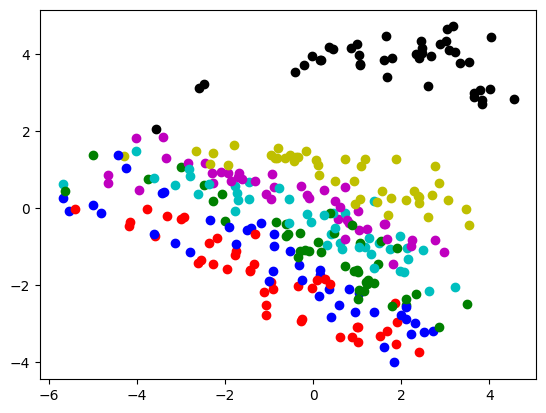

: 

In [ ]:
V_0, m_v_0, std_v_0 = V_matrix(embs_a0, nb_dim=2)
visualize_emb(embs_a0, V_0, m_v_0, ent_ords0)